<a href="https://colab.research.google.com/github/Sebas-Atehortua/Integracion-de-Datos-y-Prospectiva/blob/main/Modelo_Riesgo_FINTECH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Caracterización del Riesgo Operacional - Caso FINTECH**

El presente modelo tiene como objetivo estimar las pérdidas financieras de una FINTECH derivadas de fallos tecnológicos en sus canales electrónicos. Se busca caracterizar la Distribución Agregada de Pérdidas (LDA) para determinar el capital necesario para cubrir eventos de riesgo con un nivel de confianza del 99.9%.

Para ello, se describen las siguientes variables aleatorias para explicar este riesgo:

* **Frecuencia**: Como el número de transacciones que fallan al día. Se modela estadísticamente para entender cuántas veces ocurre el riesgo en un periodo determinado.
* **Severidad**: Define el impacto económico promedio (costo tecnológico) por cada evento de fallo. Este parámetro permite medir la magnitud individual de las pérdidas.
* **Distribución Agregada de Pérdidas (LDA)**: Que resulta de multiplicar ambas variables anteriores.

Dado que la pérdida agregada no es una simple multiplicación de promedios, utilizaremos el Método de Montecarlo para realizar la convolución de las distribuciones de frecuencia y severidad.

1. *Pérdidas Esperadas (EL)*: El promedio de la distribución resultante.
2. *Pérdidas No Esperadas (UL)*: El capital en riesgo calculado como la diferencia entre el escenario de estrés y la media ($UL = SL - EL$).
3. *Stress Losses (SL)*: El percentil 99.9% que representa las pérdidas catastróficas







0. Se cargan librerías de trabajo

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns # En esta librería se hará el trabajo estadístico
import matplotlib.pyplot as plt

# Configuración de estilo
sns.set_theme(style="whitegrid")

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Se cargan los archivos de trabajo

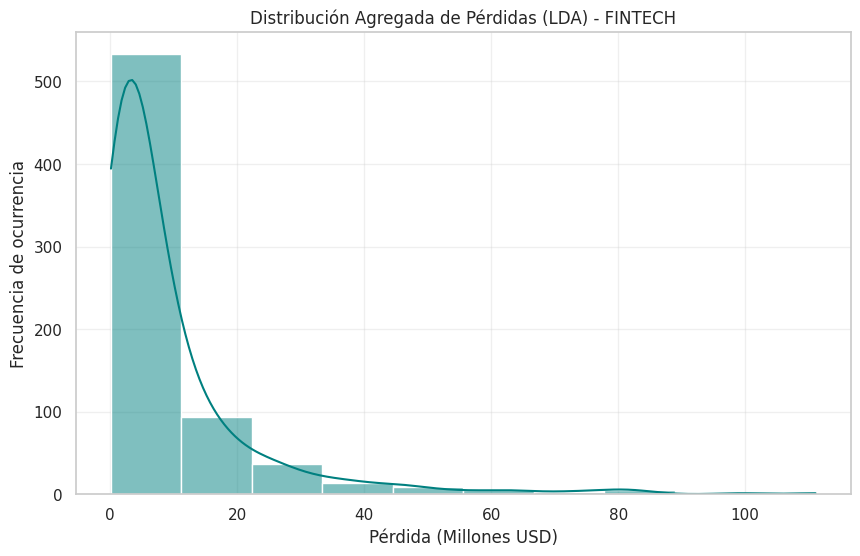

In [8]:
nxl='/content/drive/MyDrive/Proyecto FINTECH/1. FallasTecnológicas.xlsx'
XDB=pd.read_excel(nxl, sheet_name=0)
XDB.head(10)

# Procedemos con la construcción de la distribución agregada de las pérdidas
Freq=XDB.iloc[:,3]
Sev=XDB.iloc[:,4]
LDA=Freq*Sev

# Se procede con la construcción de la distribución agregada de las pérdidas

# Visualización inicial mediante la librería Seaborn

plt.figure(figsize=(10, 6))
sns.histplot(LDA, bins=10, kde=True, color='teal')
plt.title("Distribución Agregada de Pérdidas (LDA) - FINTECH")
plt.xlabel("Pérdida (Millones USD)")
plt.ylabel("Frecuencia de ocurrencia")
plt.grid(True, alpha=0.3)
plt.show()

2. Se procede con la clusterización estadística, la cual está definida mediante el Histograma de Frecuencias.

In [14]:
np.set_printoptions(precision=2, suppress=True)

NI = 10 # Número de intervalos/clústers
counts, bin_edges = np.histogram(LDA, bins=NI)

print("El número de datos por intervalo es:")
print(counts)
print("Los intervalos inferiores:")
print(bin_edges[:-1])
print("Los intervalos superiores:")
print(bin_edges[1:])
XC=(bin_edges[:-1]+bin_edges[1:])/2
print("Los intervalos centrales son:")
print(XC)

# Configuración de la tabla de clústers
XC = (bin_edges[:-1] + bin_edges[1:]) / 2 # Marcas de clase
Tabla = np.column_stack((bin_edges[:-1], bin_edges[1:], XC, counts))
df_clusters = pd.DataFrame(Tabla, columns=['Límite Inf', 'Límite Sup', 'Marca Clase', 'Frec. Absoluta'])


print("Tabla de Distribución de Frecuencias (LDA):")
display(df_clusters.head(NI))

El número de datos por intervalo es:
[533  93  37  14   9   5   3   5   1   1]
Los intervalos inferiores:
[ 0.14 11.24 22.33 33.42 44.52 55.61 66.71 77.8  88.89 99.99]
Los intervalos superiores:
[ 11.24  22.33  33.42  44.52  55.61  66.71  77.8   88.89  99.99 111.08]
Los intervalos centrales son:
[  5.69  16.78  27.88  38.97  50.07  61.16  72.25  83.35  94.44 105.54]
Tabla de Distribución de Frecuencias (LDA):


,Límite Inf,Límite Sup,Marca Clase,Frec. Absoluta
0,0.14230,11.23637,5.689335,533.0
1,11.23637,22.33044,16.783405,93.0
2,22.33044,33.42451,27.877475,37.0
3,33.42451,44.51858,38.971545,14.0
4,44.51858,55.61265,50.065615,9.0
5,55.61265,66.70672,61.159685,5.0
6,66.70672,77.80079,72.253755,3.0
7,77.80079,88.89486,83.347825,5.0
8,88.89486,99.98893,94.441895,1.0
9,99.98893,111.08300,105.535965,1.0


3. Se calculan las métricas estadística de Tendencia Central y Dispersión (media, desviación, asimetría y kurtosis)

In [12]:
from scipy.stats import skew, kurtosis


# Métricas de abstracción
u = np.mean(LDA)
var = np.var(LDA)
sigma = np.std(LDA)
skewness_lda = skew(LDA)
kurtosis_lda = kurtosis(LDA)

# Cálculo de Parámetros de Riesgo (AMA)
# Stress Loss (SL) al 99.9% de confiabilidad
sl_999 = np.percentile(LDA, 99.9)
# Expected Loss (EL) es la media
el = u
# Unexpected Loss (UL) = SL - EL
ul = sl_999 - el

# DataFrame consolidado de resultados
df_final = pd.DataFrame({
    'Métrica': ['Media (EL)', 'Varianza', 'Desviación', 'Asimetría', 'Curtosis', 'OpVar (99.9%)', 'Pérdida No Esperada (UL)'],
    'Valor': [u, var, sigma, skewness_lda, kurtosis_lda, sl_999, ul]
})

# Se parametriza aproximación de números decimales
display(df_final.style.format({"Valor": "{:,.2f}"}))

,Métrica,Valor
0,Media (EL),9.45
1,Varianza,187.89
2,Desviación,13.71
3,Asimetría,3.35
4,Curtosis,14.17
5,OpVar (99.9%),102.90
6,Pérdida No Esperada (UL),93.45


4. Análisis mediante simulación de Montecarlo

Con el fin de poder simular o proyectar más allá de los datos brindados la simulación Montecarlo es una herramienta para evaluar un escenario extremo que aún no ha ocurrido, pero que es estadísticamente posible.